---
title: Auxilliary Networks
subtitle: Empowering Injective Networks
date: 2025/01/25
---

We now introduce, **_Auxilliary Networks_**, additions to the basic Injective Network architecture that enhances their
representation power.

In [1]:
# Basic imports
import torch
from torch import nn

from assets.shapes import square, circle, stanford_bunny
from assets.loss_functions import mse
from assets.utils import automate_training, plot_curves

# Pre-Auxilliary Networks

## Closed Condition: A Closer Look
Let's first try fitting an Injective Network to a square using the `PReLU` function. Indeed as
[discussed before](#why_prelu) the `PReLU` activation does not guarantee non-self-intersection but
we use it to gain insights.

Epoch: [   1/1000]. Loss:    1.420825
Epoch: [ 200/1000]. Loss:    0.016310
Epoch: [ 400/1000]. Loss:    0.013031
Epoch: [ 600/1000]. Loss:    0.012490
Epoch: [ 800/1000]. Loss:    0.012337
Epoch: [1000/1000]. Loss:    0.012280


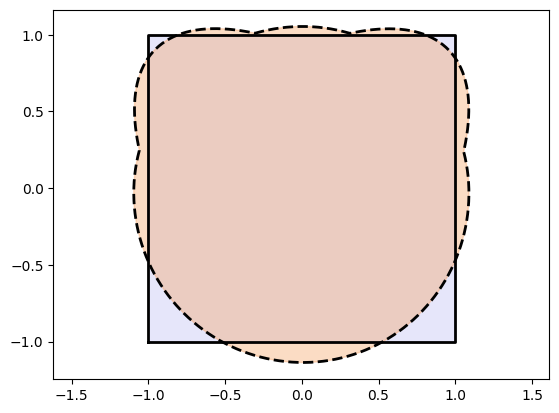

In [2]:
from assets.networks import InjectiveNet

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
X_t_square = square(num_pts)

square_net = InjectiveNet(layer_count = 2, act_fn = nn.PReLU)
automate_training(
    model = square_net, loss_fn = mse, X_train = t, Y_train = X_t_square,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

X_p_square = square_net(t)
plot_curves(X_p_square, X_t_square)

We observe that the fit is really bad.

This is because the network first transforms the interval $t\in [0, 1]$ to a circle and then deeper
layers try to transform that to a square. This is not an easy task as the network has to transform
the circle arcs to the four straight edges.

Let's have a look at the first transformation as discussed in the section
[](#closed_transformation):
:::{math}
C(t) = 
\begin{bmatrix}
cos(2\pi t)\\
sin(2\pi t)
\end{bmatrix}
:::

The point $[\cos(2\pi t), \sin(2\pi t)]$ is a point on the unit circle centered at the origin. What
is happening here is that the open interval $t \in [0, 1]$ is transformed to a circle that makes
sure that the first and the last point are the same and when fed into the network lead to the same
output point and hence create closed curves. This is explained visually in
[](#closed_condition_linesegment_to_circle).
:::{figure} assets/closed_condition_linesegment_to_circle.svg
:label: closed_condition_linesegment_to_circle
:alt: Transforming the line segment [0, 1] to the unit circle centered at the origin.
:height: 150px
Transforming the line segment $[0, 1]$ to the unit circle centered at the origin.
:::

We could have also achieved the closed condition by transforming to a square instead of a circle.
For the above problem of fitting to a square this should help immensely as the Injective Network has
to learn the identity mapping only! This is easy to do when using the `PReLU` activation.

::::{dropdown} Code for transforming $[0, 1]$ to unit square
:::{literalinclude} assets/shapes.py
:start-at: square_from_t
:end-at: return
:::
::::

In [3]:
import torch
from torch import nn

from assets.shapes import square_from_t

class InjectiveNet_SquareClosed(nn.Module):
    def __init__(self, layer_count, act_fn):
        super().__init__()

        # Transform from t on the [0, 1] interval to unit square for closed shapes
        self.closed_transform = square_from_t

        layers = []
        for i in range(layer_count):
            layers.append(nn.Linear(2, 2))
            layers.append(act_fn())
        
        self.linear_act_stack = nn.Sequential(*layers)
    
    def forward(self, t):
        x = self.closed_transform(t)
        x = self.linear_act_stack(x)
        return x

Epoch: [   1/1000]. Loss:    1.627710
Epoch: [ 200/1000]. Loss:    0.000000
Epoch: [ 400/1000]. Loss:    0.000000
Epoch: [ 600/1000]. Loss:    0.000000
Epoch: [ 800/1000]. Loss:    0.000000
Epoch: [1000/1000]. Loss:    0.000000


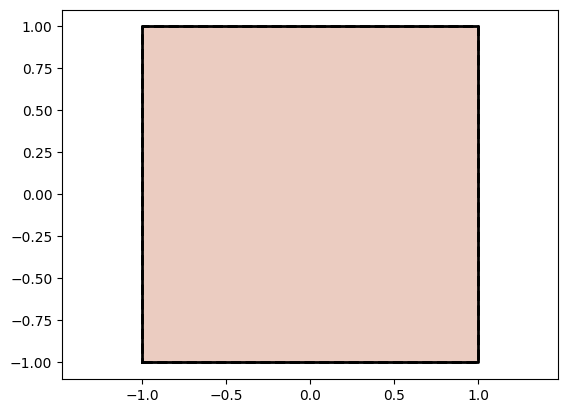

Layer: linear_act_stack.0.weight | Values : tensor([[1.0000e+00, 8.2669e-10],
        [5.5976e-14, 1.0000e+00]], grad_fn=<SliceBackward0>) 

Layer: linear_act_stack.0.bias | Values : tensor([9.6202e-08, 7.5115e-08], grad_fn=<SliceBackward0>) 

Layer: linear_act_stack.1.weight | Values : tensor([1.0000], grad_fn=<SliceBackward0>) 



In [4]:
# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
X_t_square = square(num_pts)

square_net = InjectiveNet_SquareClosed(layer_count = 1, act_fn = nn.PReLU)
automate_training(
    model = square_net, loss_fn = mse, X_train = t, Y_train = X_t_square,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

X_p_square = square_net(t)
plot_curves(X_p_square, X_t_square)

# Print model parameters after learning
for name, param in square_net.named_parameters():
    print(f"Layer: {name} | Values : {param[:2]} \n")

Observe above that the network indeed learns the identity mapping as the linear transformation
matrix ends up as the identity matrix and the PReLU activation function ends up as $x$ that is the
identity map with the slope as 1 and bias being 0.

## Pre-Auxilliary Network
Indeed we could have transformed to any simple closed curve first and then attached the neural
network layers after that. But since representing general simple closed curves is what we are trying
to achieve, we can do a simpler thing. We transform the interval $[0, 1]$ to a closed loop
represented through polar coordinates in the form:
$$
r = f(\theta), \quad \theta \in [0, 2\pi)
$$
where $\theta = 2\pi t$ with $t$ in $[0, 1]$.

We can then use the vector $[r \cos(\theta), r \sin(\theta)]^{T}$ as the first layer and attach
the usual Injective Network layers on top. This transformation from $t$ to the vector
$[r \cos(\theta), r \sin(\theta)]^{T}$ is injective and satisfies the condition $F(0) = F(1)$ and
thus will create closed curves.

The function $f$ can be represented using a full neural network with no additional constraints
except that the output has to be positive. We call this network the _**Pre-Auxilliary Network**_.

The basic idea is that the Pre-Auxilliary Network will provide a favorable initial shape to the
Injective Network and make its learning task simpler.

In [5]:
class PreAuxNet(nn.Module):
    def __init__(self, layer_count, hidden_dim):
        super().__init__()

        # Pre-Auxilliary net needs closed transform to get same r at theta = 0, 2pi
        self.closed_transform = lambda t: torch.hstack([
            torch.cos(2 * torch.pi * t),
            torch.sin(2 * torch.pi * t)
        ])

        layers = [nn.Linear(2, hidden_dim), nn.LazyBatchNorm1d(), nn.ReLU()]
        for i in range(layer_count):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LazyBatchNorm1d())
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.ReLU())

        self.forward_stack = nn.Sequential(*layers)
    
    def forward(self, t):
        unit_circle = self.closed_transform(t) # Rows are cos(theta), sin(theta)
        r = self.forward_stack(unit_circle)
        x = r * unit_circle # Each row is now r*cos(theta), r*sin(theta)
        return x

In [6]:
class PreAux_InjectiveNet(nn.Module):
    def __init__(self, layer_count_inj, act_fn_inj, layer_count_preaux, hidden_dim_preaux):
        super().__init__()

        # Transform from t on the [0, 1] interval to unit square for closed shapes
        self.closed_transform = PreAuxNet(layer_count_preaux, hidden_dim_preaux)

        layers = []
        for i in range(layer_count_inj):
            layers.append(nn.Linear(2, 2))
            layers.append(act_fn_inj())
        
        self.linear_act_stack = nn.Sequential(*layers)
    
    def forward(self, t):
        x = self.closed_transform(t)
        x = self.linear_act_stack(x)
        return x

Epoch: [   1/1000]. Loss:    1.525636
Epoch: [ 200/1000]. Loss:    0.004310
Epoch: [ 400/1000]. Loss:    0.003470
Epoch: [ 600/1000]. Loss:    0.003375
Epoch: [ 800/1000]. Loss:    0.003360
Epoch: [1000/1000]. Loss:    0.003355


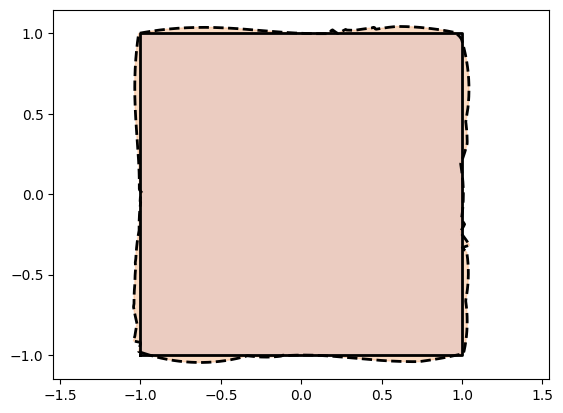

In [7]:
# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
X_t_square = square(num_pts)

square_net = PreAux_InjectiveNet(
    layer_count_inj = 1, act_fn_inj = nn.PReLU,
    layer_count_preaux = 3, hidden_dim_preaux = 5
)
automate_training(
    model = square_net, loss_fn = mse, X_train = t, Y_train = X_t_square,
    learning_rate = 0.01, epochs = 1000, print_cost_every = 200
)

X_p_square = square_net(t)
plot_curves(X_p_square, X_t_square)

Great! Using a Pre-Auxilliary Network helps us build an Injective Network on top of a favorable
closed transform. This therefore helps us cover both the circle and the square fitting cases without
specifying a particular initial transform such as the circle or square. Pre-Auxilliary Networks are
therefore a way of adding to the capacity of Injective Networks using full scale neural networks.

Epoch: [   1/1000]. Loss: 4623.556152
Epoch: [ 200/1000]. Loss:  288.236176
Epoch: [ 400/1000]. Loss:  118.446892
Epoch: [ 600/1000]. Loss:   65.680824
Epoch: [ 800/1000]. Loss:   58.530506
Epoch: [1000/1000]. Loss:   58.060734


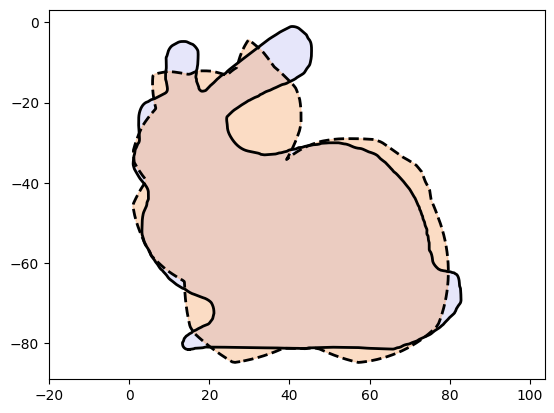

In [8]:
# Generate target curve points
X_t_bunny = stanford_bunny(num_points = 1000)
num_pts = X_t_bunny.shape[0]
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)

bunny_net = PreAux_InjectiveNet(
    layer_count_inj = 1, act_fn_inj = nn.PReLU,
    layer_count_preaux = 2, hidden_dim_preaux = 50
)
automate_training(
    model = bunny_net, loss_fn = mse, X_train = t, Y_train = X_t_bunny,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

X_p_bunny = bunny_net(t)
plot_curves(X_p_bunny, X_t_bunny)

We now look at another technique that allows us to use full scale neural networks to augment the
power of Injective Networks.

# Post-Auxilliary Networks

## More Representation Power: Augmenting in Polar Coordinates
The Injective Network architecture can represent simple closed curves. But as we saw the requirement
of network injectivity for imparting non-self-intersection to the parameterization restricted the
hidden layer size to 2. Therefore the only thing we can control for increasing representation power
is the network depth.

There is a way of working with polar coordinates where we can post-augment the parameterization with
a general neural network giving a boost to representation power. We discuss this technique now. But
first we need to discuss the polar version of the Injective Network.

### Polar Neural Injective Curves
Consider first a polar setup of the parameterization similar to the cartesian case:
\begin{align*}
r &= f(t)\\
\theta &= g(t), \quad t \in [0, 1)
\end{align*}

Again as before we look at a vector-valued equivalent:
:::{math}
F: t \rightarrow
\begin{bmatrix}
r\\
\theta
\end{bmatrix}
:::

We use the same network architecture as before with the only difference that now the output is
$[r, \theta]^{T}$:
:::{figure} assets/polar_architecture.svg
:label: polar_architecture
:alt: Figure showing a neural network architecture for polar representation of simple closed curves.
:height: 200px
The network architecture for polar representation of simple closed curves looks deceptively similar
to the one for cartesian coordinates with only the interpretation of the outputs being
$[r, \theta]^{T}$ instead of $[x, y]^{T}$. But for the polar representation we need more constraints
to hold to guarantee simple closed curves.
:::

The network architecture for the polar representation looks deceptively similar to the one for
cartesian coordinates with only the interpretation of the outputs being $[r, \theta]^{T}$ instead of
$[x, y]^{T}$. But for the polar representation we need additional constraints to hold to guarantee
simple closed curves.

Positive $r$
: The polar representation requires that $r$ is positive. The above architecture by default puts no
restriction on what values $r$ can take. To generate only positive $r$ values the activation
function used at the last layer should be such that its outputs are always positive. Note that this
activation function should still be injective. Valid activation functions include $sigmoid$,
$softplus$, modified $tanh$ or $ELU$ etc. An example modification of $tanh$ would be to add 1 to it
and use $tanh(x) + 1$ as the final activation function, this works as $tanh$ is injective with range
$(-1, 1)$.

Restricting $\theta \in [0, 2 \pi)$
: Once we make sure that we choose the right activation function that only outputs positive values
we need to make sure of the range of $\theta$ for a couple of reasons:
    1. The first is related to self-intersection. The mapping from $t \to [r, \theta]$ is injective.
    But the curve it may trace out in the current form may self-intersect. Consider as an e.g. the
    points $[1, \pi]$ and $[1, 3\pi]$. These are different outputs and does not violate injectivity
    of the network but they correspond to the same point in the plane!
    2. The second one is a representation problem. Let's say we use the last layer activation
    function to be $tanh + 1$. This function has the range $(0, 2)$ and therefore this will also be
    the possible $\theta$ that we can generate. Thus, our curves will all be limited to
    $\theta \in (0, 2)$. Of course, this is an artifact of using $tanh + 1$ and a different
    activation function like the $ELU + 1$ would not have this issue, but it will suffer from the
    first issue above.

    Therefore the possible activation functions we can use at the last layer must be restricted to
    those that can further be scaled to have a range $[0, 2\pi)$. One valid choice would be the
    function $2\pi(tanh + 1)$.


**_Note:_** There is then also the concern on the range of r

### Post-Auxilliary Networks

Now consider a polar representation of the form:
$$
r = h(\theta), \quad \theta \in [0, 2\pi)
$$

As we discussed before this is a guaranteed non-self-intersecting representation but suffers from
the general curve representation problem discussed in the section
[](#naive-usage-of-polar-coordinates-the-representation-power-problem)

But this can be a very powerful representation as we can use a full scale neural network to
parameterize $f(\theta)$. We now see a way of combining the injective polar representation with this
parameterization.

**_Note_**: The final activation function of the neural network should be chosen such that the
outputs are always positive to agree with $r$ being positive.

Probably the simplest thing to do would be to simply add the outputs of the two networks. One would
do this by adding the $r$ value output from the auxilliary network to the different $r$ values that
are output from the injective network at any given $\theta$. But performing this directly has a
problem. The auxilliary network is defined at all $\theta$ by definition but the injective network
may not output some values of $\theta$ and therefore we cannot add the two. This is shown in
[](post_auxilliary_network_addition_problem).
:::{figure} assets/post_auxilliary_network_addition_problem.svg
:label: post_auxilliary_network_addition_problem
:alt: Figure showing a neural network architecture for polar representation of simple closed curves.
:height: 350px
We cannot add the two networks at $\theta = \pi$ since the injective network does not output all
possible $\theta$ as $t$ varies from $[0, 1)$.
:::

But there is a simple way of bypassing this problem. The basic idea is to use $r$ values only at
$t$ values that lead to valid $\theta$. The valid $\theta$ are generated as $g(t)$. Therefore the
corresponding $r = h(\theta) = h(g(t))$ are the $r$ values generated at valid $\theta$ that occur as
$t$ is traversed from $[0, 1)$.

Consider a vector-valued mapping associated with the auxilliary network:
:::{math}
A: t \rightarrow
\begin{bmatrix}
h(g(t))\\
0
\end{bmatrix}
:::
Note this requires that we first feed in $t$ into the injective network, get the corresponding
$\theta$ and then feed that into the auxilliary network to generate the $r$ for the $A$ mapping.

We now have the following two vector-valued mappings:
:::{math}
F: t \rightarrow
\begin{bmatrix}
f(t)\\
g(t)
\end{bmatrix}
\quad
A: t \rightarrow
\begin{bmatrix}
h(g(t))\\
0
\end{bmatrix}
:::

Consider the addition of these:
:::{math}
F + A: t \rightarrow
\begin{bmatrix}
f(t) + h(g(t))\\
g(t)
\end{bmatrix}
:::

We now need to prove that this mapping generates simple closed curves. This is quite intuitive and
the proof is as follows:

Closed
: The curves will be closed if $(F + A)(0) = (F + A)(1)$. But we have
    $F(0) = F(1)$ as $F$ is the injective network. That is,
    $$
    (f(0), g(0)) = (f(1), g(1))
    $$
    We have $A(0) = (h(g(0)), 0)$ and $A(1) = (h(g(1)), 0)$. Now since $g(0) = g(1)$ we also have
    $A(0) = A(1)$ and hence the curves will be closed.

Simple
: The curves will be simple if the mapping $F + A$ is injective. Which is true if:
    $$
    t_1 \neq t_2 \implies (F + A)(t_1) \neq (F + A)(t_2)
    $$
    We start with the assumption that $F + A$ is not injective. That is for some $t_1$ and $t_2$ the
    outputs are the same. Then we have:
    $$
    g(t_1) &= g(t_2)
    $$
    and
    $$
    &f(t_1) + h(g(t_1)) = f(t_2) + h(g(t_2)) \\
    \implies &f(t_1) + h(g(t_1)) = f(t_2) + h(g(t_1)) \\
    \implies &f(t_1) = f(t_2)
    $$
    But this means that $F(t_1) = F(t_2)$ which is a **contradiction** as $F$ is the injective
    network. Therefore our original assumption that $F + A$ is not injective is false, and we
    conclude that the mapping $F + A$ is indeed injective.


[](#post_auxilliary_network) shows the architecture for the augmented network
:::{figure} assets/post_auxilliary_network.svg
:alt: Combination of the injective network and the auxilliary network in the correct way.
:label: post_auxilliary_network
:height: 200px
First $t$ is fed into the injective network to obtain its $r_i$ and $\theta_i$ output. This
$\theta_i$ is then fed into the auxilliary network to generate $r_a$ which is then added to $r_i$ to
generate the final value.
:::